In [1]:
import sys
import pathlib
pth=str(pathlib.Path().absolute())
sys.path.append(('\\').join(pth.split('\\')[:-1])+"\\Utils")
from Utilities import *

In [2]:
def get_SD_by_format(f,ind1,ind2,j):
    x=np.mean(f[ind1,ind2,j.reshape(-1,1)],axis=1)
    u=np.std(f[ind1,ind2,j.reshape(-1,1)],axis=1)
    perc=np.percentile(f[ind1,ind2,j.reshape(-1,1)],np.array([0,25,50,75,100]),axis=1)
    hist=np.vectorize(pyfunc=(lambda t:np.histogram(f[ind1,ind2,t],bins=50,range=(0,255))),
                  signature='()->(j),(k)')(j)
    Mo=np.vectorize(pyfunc=(lambda x,y:y[np.where(x==np.max(x))]),signature='(j),(k)->()')(hist[0],hist[1])
    return np.vstack((x,u,perc,Mo))
v_get_SD_by_format=np.vectorize(pyfunc=get_SD_by_format,signature='(x,y,z),(a),(b),(j)->(q,w)')

def get_Hist_by_format(f,ind1,ind2,j):
    hist=np.vectorize(pyfunc=(lambda t:np.histogram(f[ind1,ind2,t],bins=50,range=(0,255))),
                  signature='()->(j),(k)')(j)
    return hist
v_get_Hist_by_format=np.vectorize(pyfunc=get_Hist_by_format,signature='(x,y,z),(a),(b),(j)->(q),(w)')

def pack_segments(DIRID,f,i):
    indx=np.where(f[:,:,9]==i)
    SD_rgb_hsv_lab=v_get_SD_by_format(f,indx[0],indx[1],dims)
    DIRID[i]['rgb_mean']=SD_rgb_hsv_lab[0,0]
    DIRID[i]['rgb_std']=SD_rgb_hsv_lab[0,1]
    DIRID[i]['rgb_per']=SD_rgb_hsv_lab[0,2]
    DIRID[i]['rgb_mo']=SD_rgb_hsv_lab[0,3]
    DIRID[i]['hsv_mean']=SD_rgb_hsv_lab[1,0]
    DIRID[i]['hsv_std']=SD_rgb_hsv_lab[1,1]
    DIRID[i]['hsv_per']=SD_rgb_hsv_lab[1,2]
    DIRID[i]['hsv_mo']=SD_rgb_hsv_lab[1,3]
    DIRID[i]['lab_mean']=SD_rgb_hsv_lab[2,0]
    DIRID[i]['lab_std']=SD_rgb_hsv_lab[2,1]
    DIRID[i]['lab_per']=SD_rgb_hsv_lab[2,2]
    DIRID[i]['lab_mo']=SD_rgb_hsv_lab[2,3]
    return 0
v_pack_segments=np.vectorize(pyfunc=pack_segments,signature="(),(x,y,z),()->()")

In [3]:
def get_Statistical_Descriptors(img,mask,n_segments=800):
    lum = np.mean(mask,axis=2).astype(int)
    mask1=lum>0

    m_slic = slic(img, n_segments=n_segments,sigma=5,slic_zero=True,mask=mask1)

    fig = plt.figure("Superpixels -- %d segments" % (500),figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(img, m_slic))
    plt.axis("off")
    
    RID=np.unique(m_slic.flatten())
    f=np.zeros((img.shape[0],img.shape[1],3+3+3+1))
    f[:,:,0:3]=img[:,:,0:3]
    f[:,:,3:6]=color.rgb2hsv(img)[:,:,0:3]
    f[:,:,6:9]=color.rgb2lab(img)[:,:,0:3]
    f[:,:,9]=m_slic

    DIRID={int(i):{'rbg_mean':np.zeros((3)),'rgb_std':np.zeros((3)),'rgb_per':np.zeros((3)),'rgb_mo':np.zeros((3)),
                   'lab_mean':np.zeros((3)),'lab_std':np.zeros((3)),'lab_per':np.zeros((3)),'lab_mo':np.zeros((3)),
                   'hsv_mean':np.zeros((3)),'hsv_std':np.zeros((3)),'hsv_per':np.zeros((3)),'hsv_mo':np.zeros((3)),
                  } for i in RID}

    v_pack_segments(DIRID,f,RID)
    return DIRID

In [2]:
name='c1anemia-300'
di=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Imagenes_originales\\'+name+'.jpg'
ROI=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Sem_Auto\\eye_'+name+'.jpg'
img = io.imread(di)
ROI = io.imread(ROI)

In [3]:
f1=open(('\\').join(pth.split('\\')[:-2])+"\\Data_base\\validcrop.txt","r")
lines=f1.readlines()
linesn=np.array(lines)
linesn=np.delete(lines,np.where(linesn=="\n"))
linesn=linesn.reshape(-1,3)
linesnc=v_replace_err(linesn)
linesnc=np.vectorize(pyfunc=lambda x:np.array([x[0].split('\n')[0]]),signature="(n)->(m)")(linesnc.reshape(-1,1)).reshape(-1,3)
xywh=linesnc[:,:2]
imgnames=linesnc[:,2]
xywh=v_no_spaces(xywh)
xywh=np.vectorize(pyfunc=(lambda x:float(x)))(xywh.reshape(1,-1)[0])
xywh=xywh.reshape(-1,4).astype(int)+1

mr=xywh[np.where(imgnames==(name+".jpg"))][0]
mask=assemble_mask(mr,img,ROI)

In [4]:
lum = np.mean(mask,axis=2).astype(int)
mask1=lum>0
m_slic = slic(img, n_segments=10,sigma=5,mask=mask1)

In [5]:
RID=np.unique(m_slic.flatten())
f=np.zeros((img.shape[0],img.shape[1],3+3+3+1))
f[:,:,0:3]=img[:,:,0:3]
f[:,:,3:6]=color.rgb2hsv(img)[:,:,0:3]
f[:,:,6:9]=color.rgb2lab(img)[:,:,0:3]
f[:,:,9]=m_slic

In [6]:
def get_Hist_by_format(f,ind1,ind2,j):
    hist=np.vectorize(pyfunc=(lambda t:np.histogram(f[ind1,ind2,t],bins=1000,range=(0,255))),
                  signature='()->(j),(k)')(j)
    return hist[0],hist[1]
v_get_Hist_by_format=np.vectorize(pyfunc=get_Hist_by_format,signature='(x,y,z),(a),(b),(j)->(j,q),(j,w)')

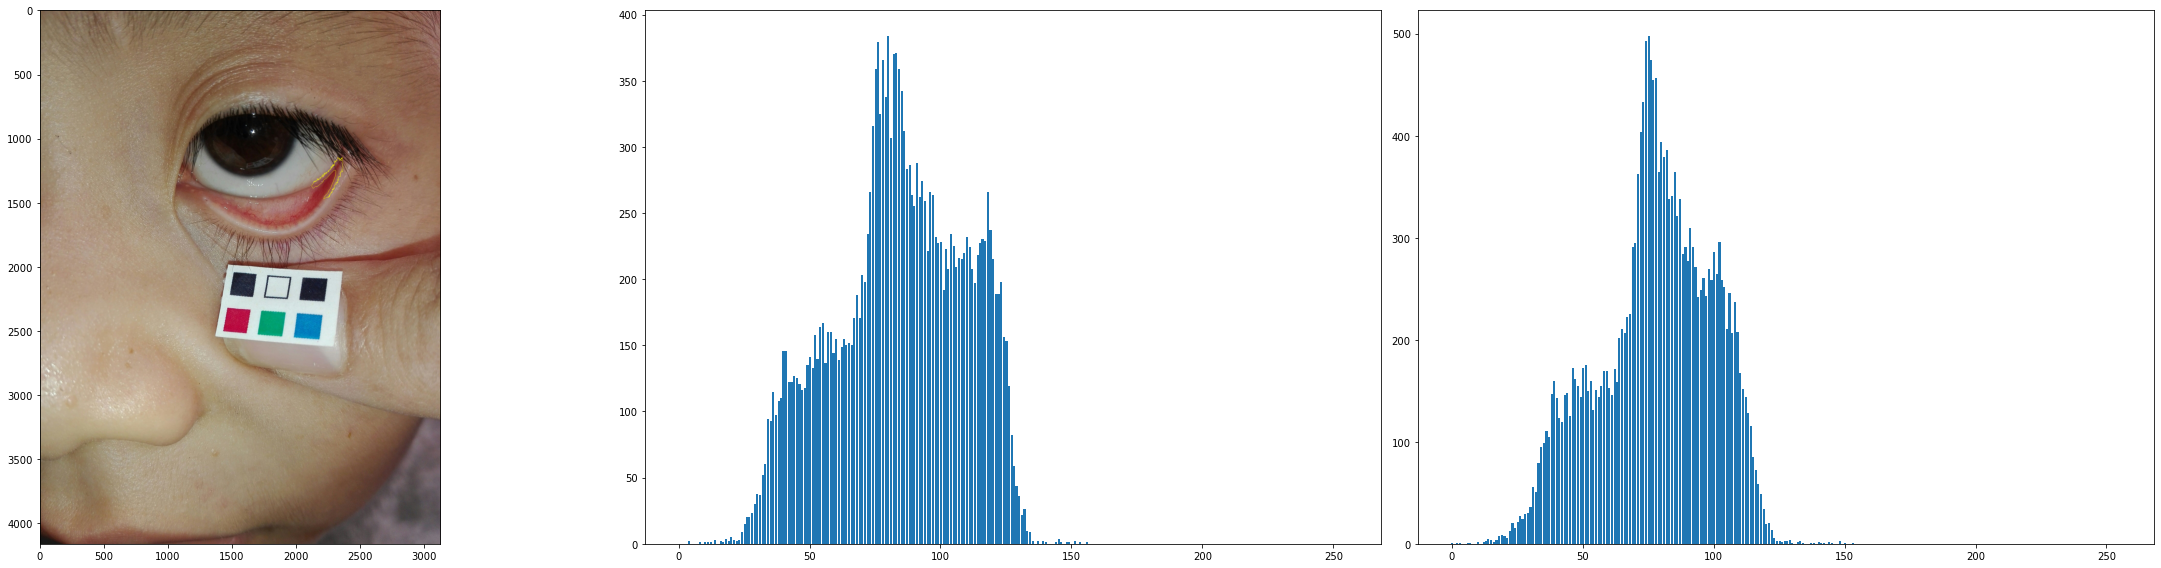

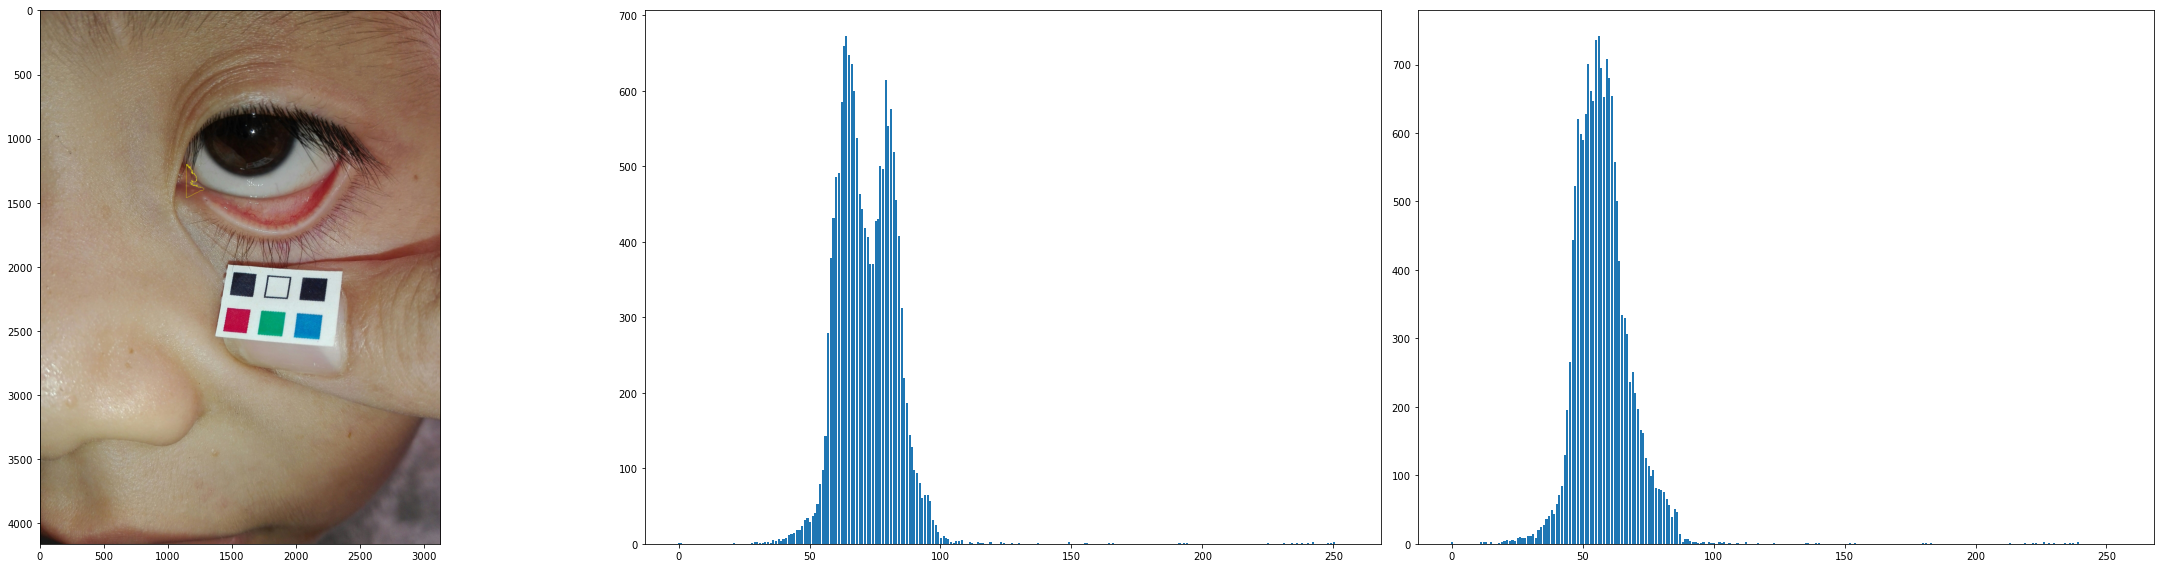

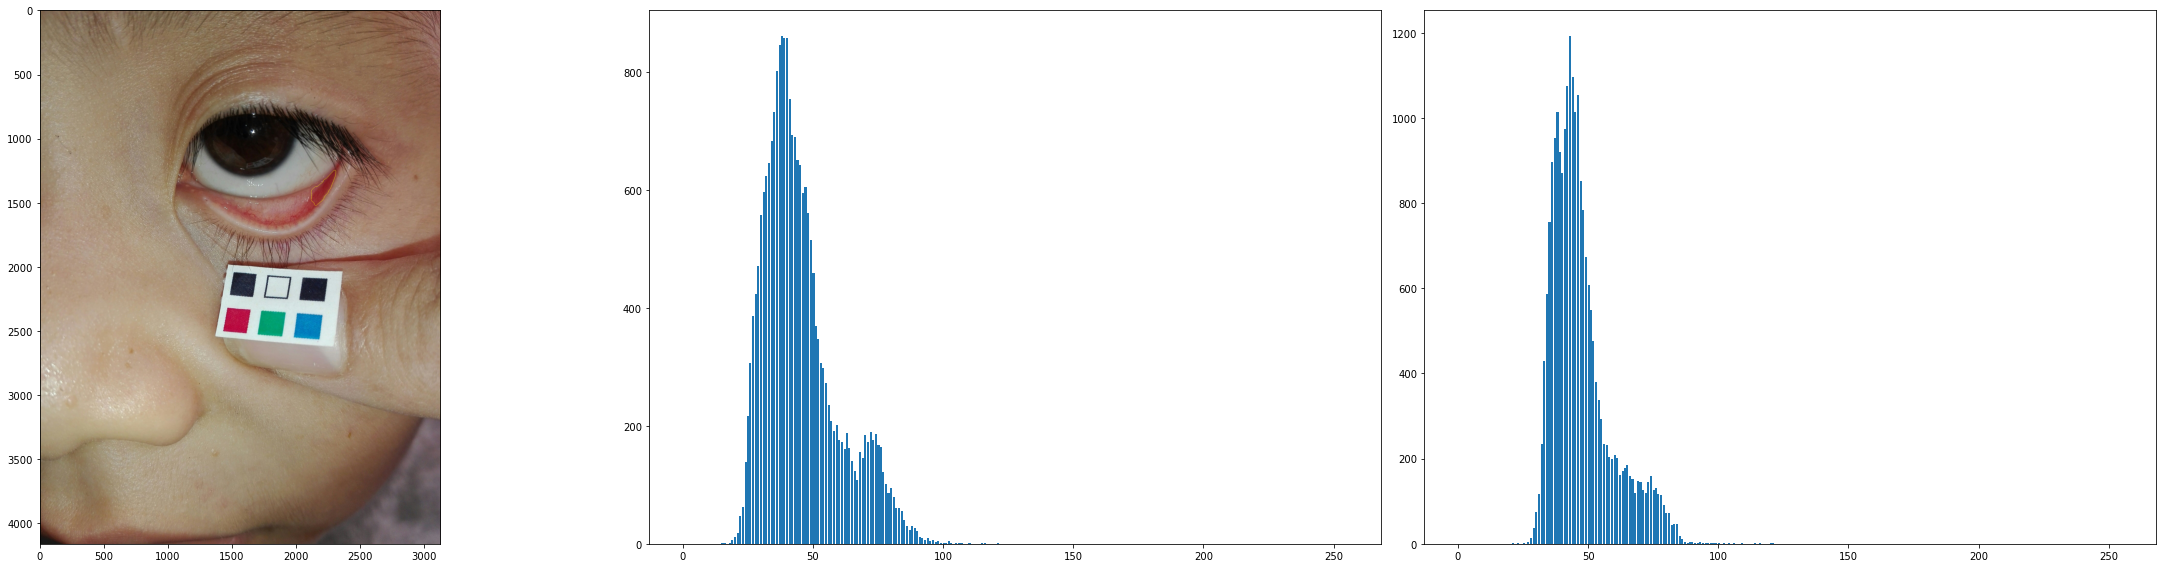

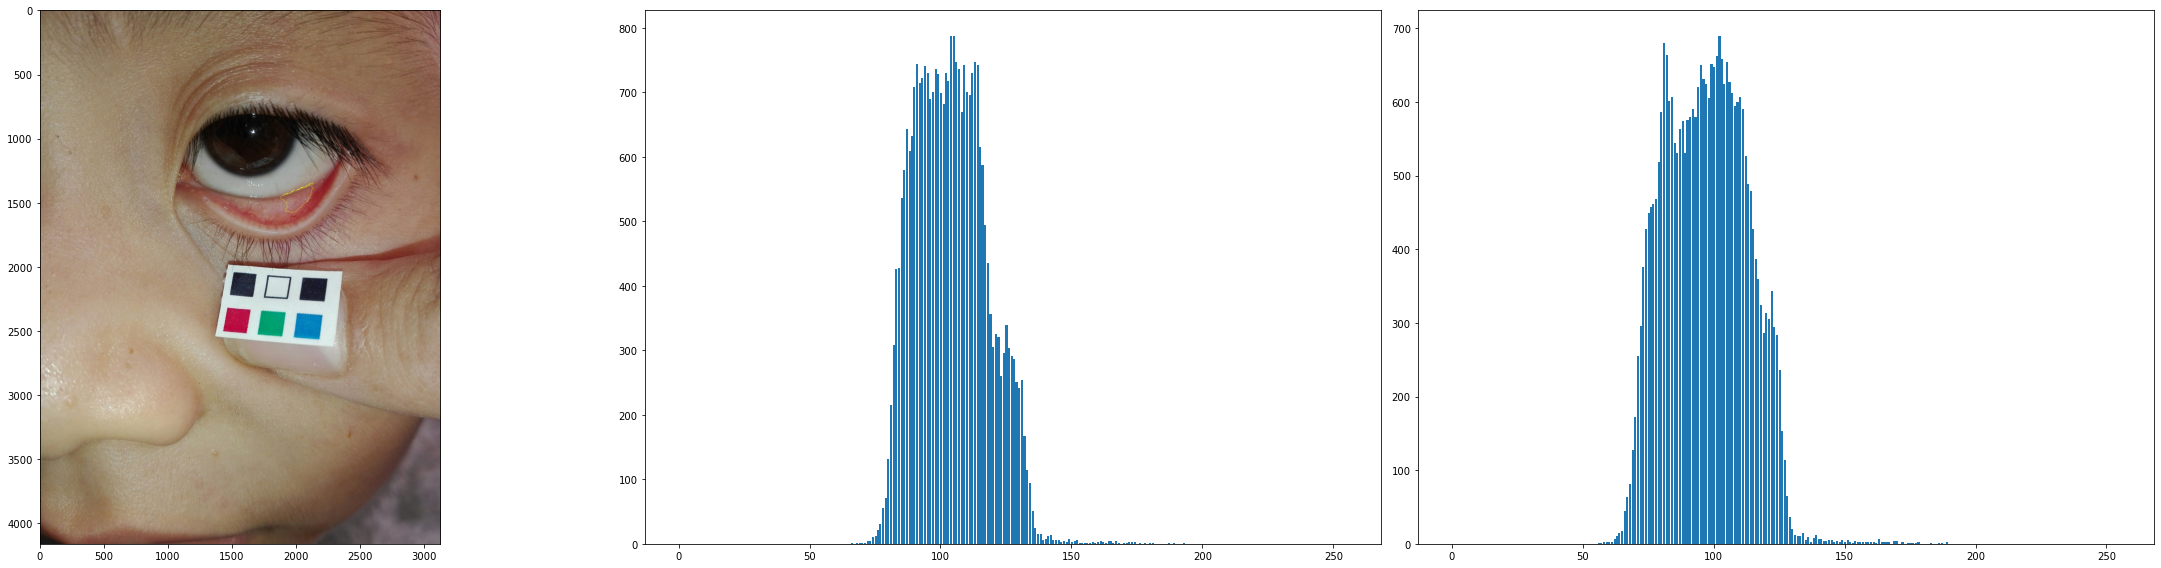

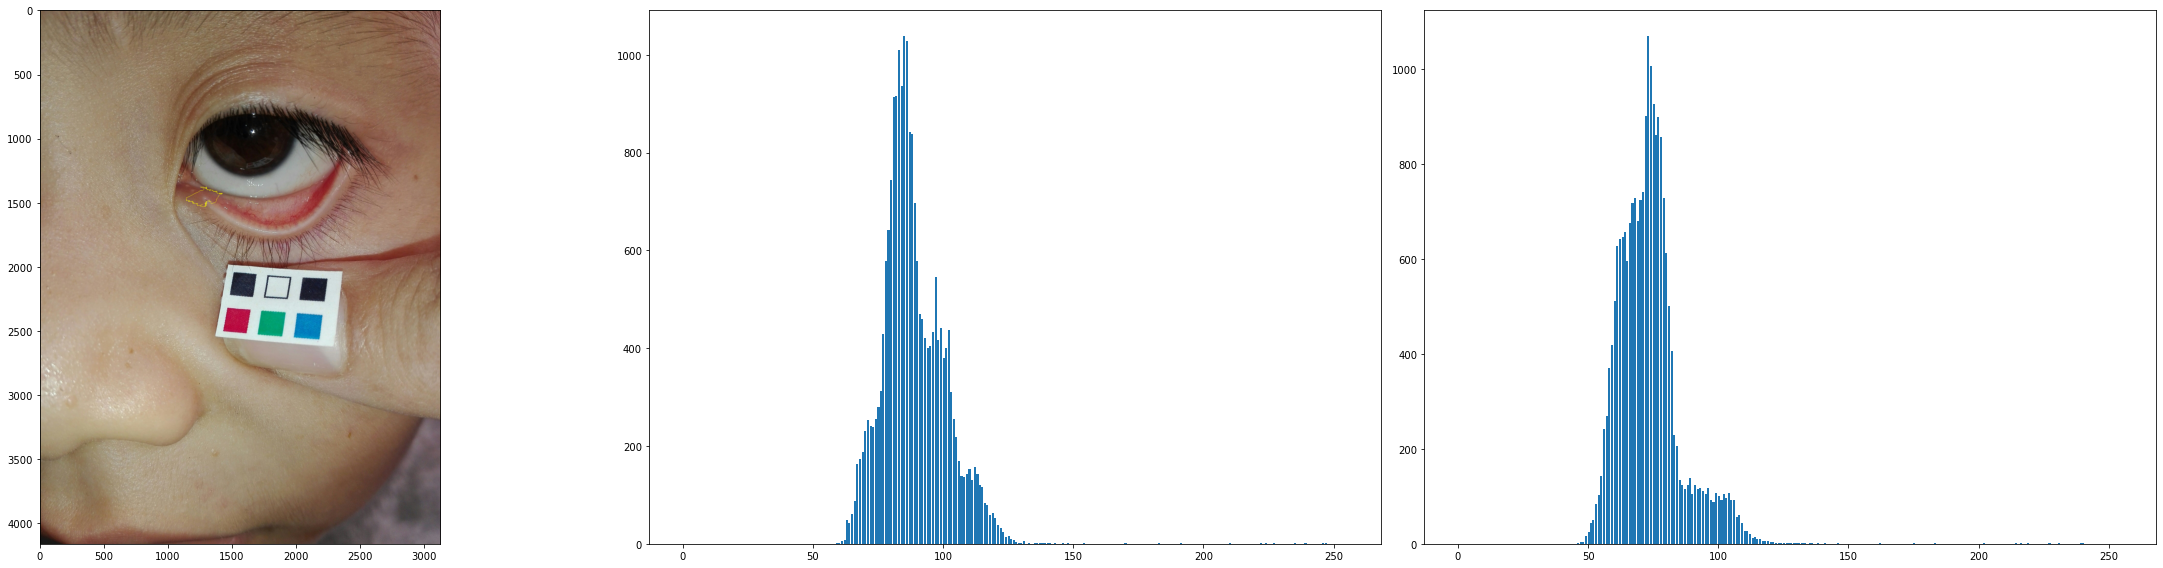

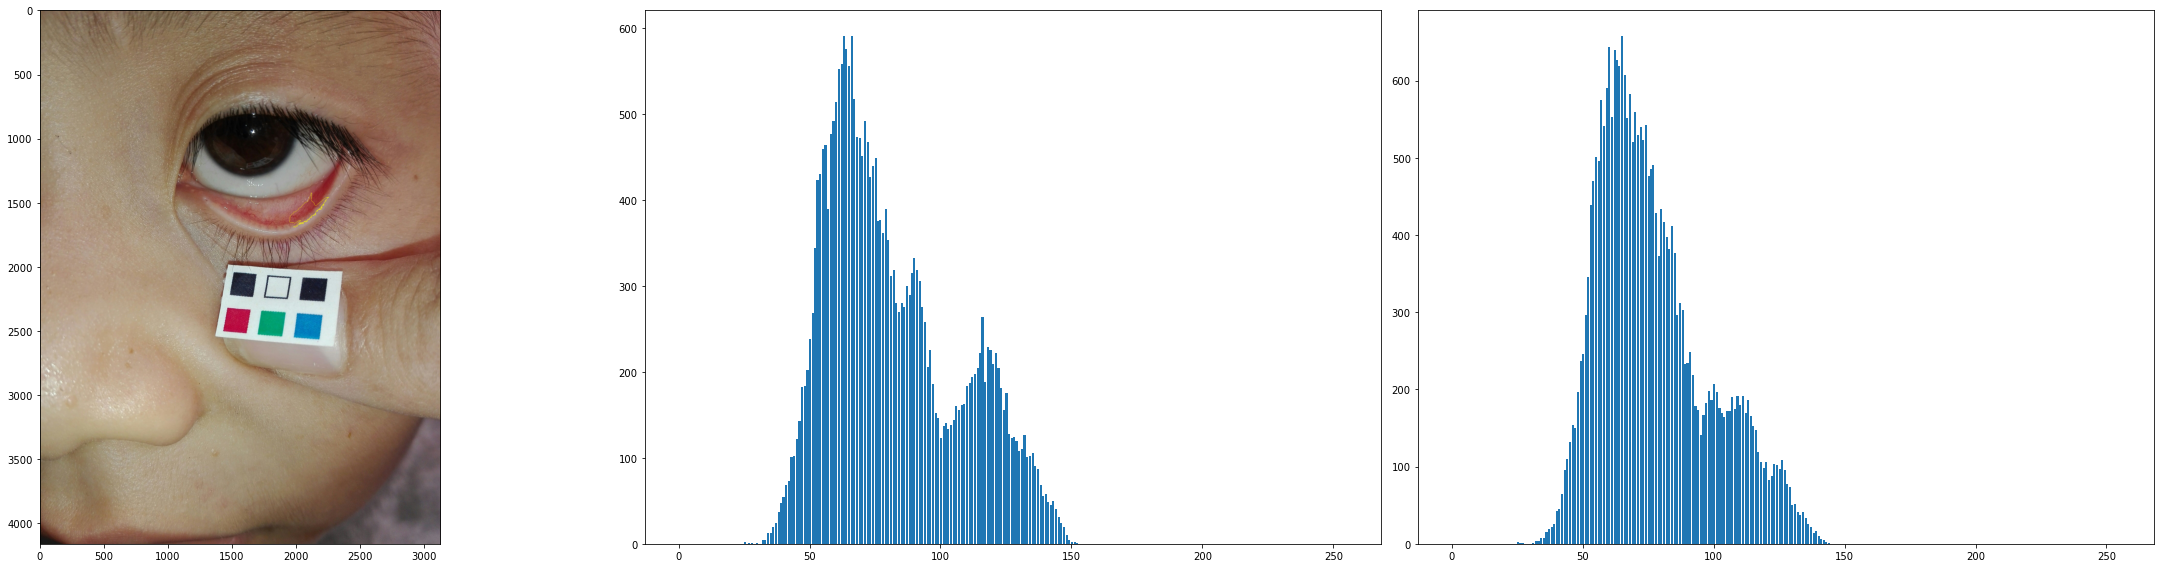

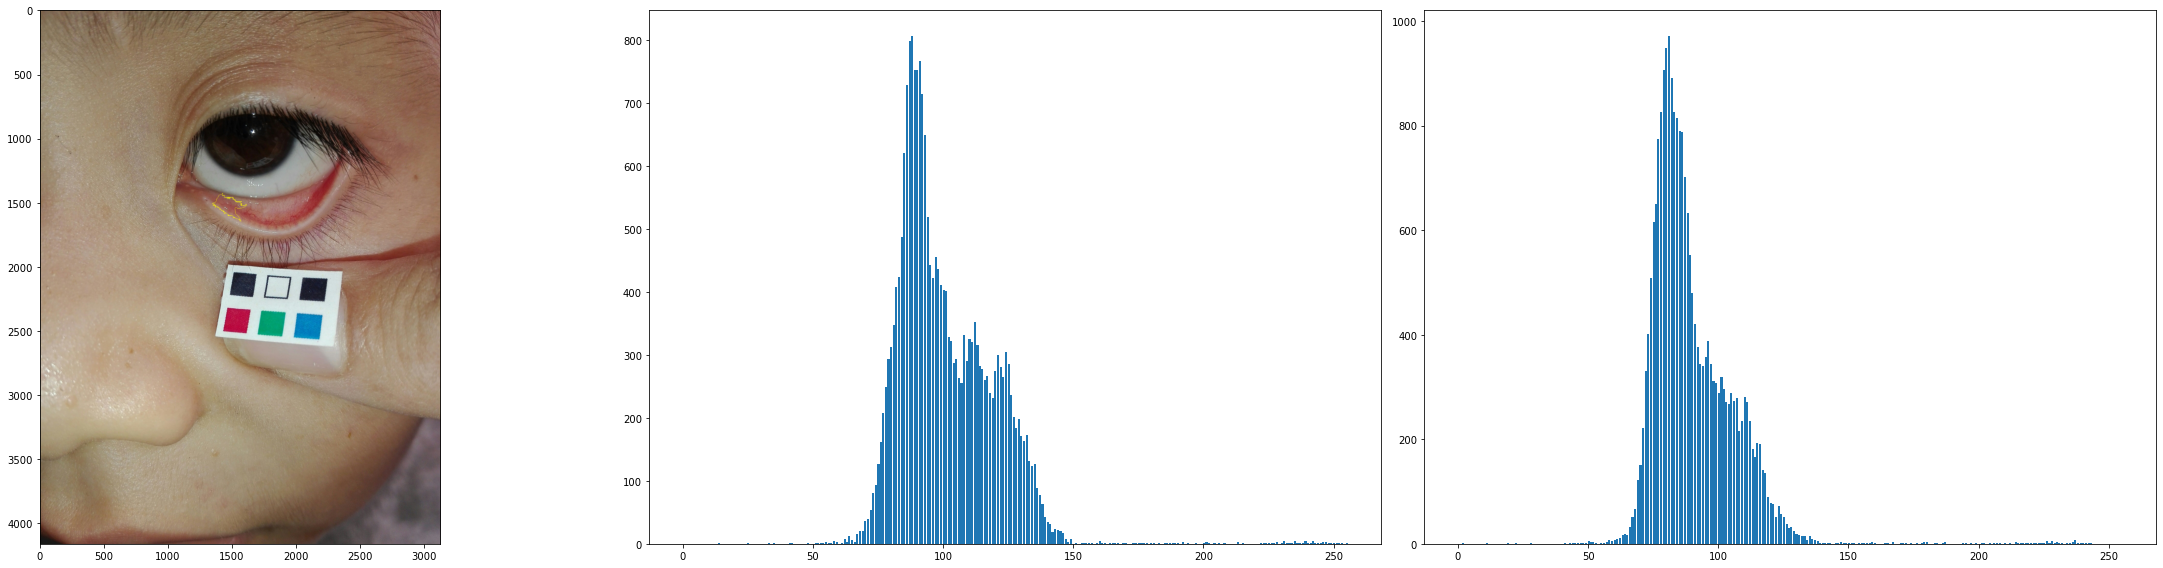

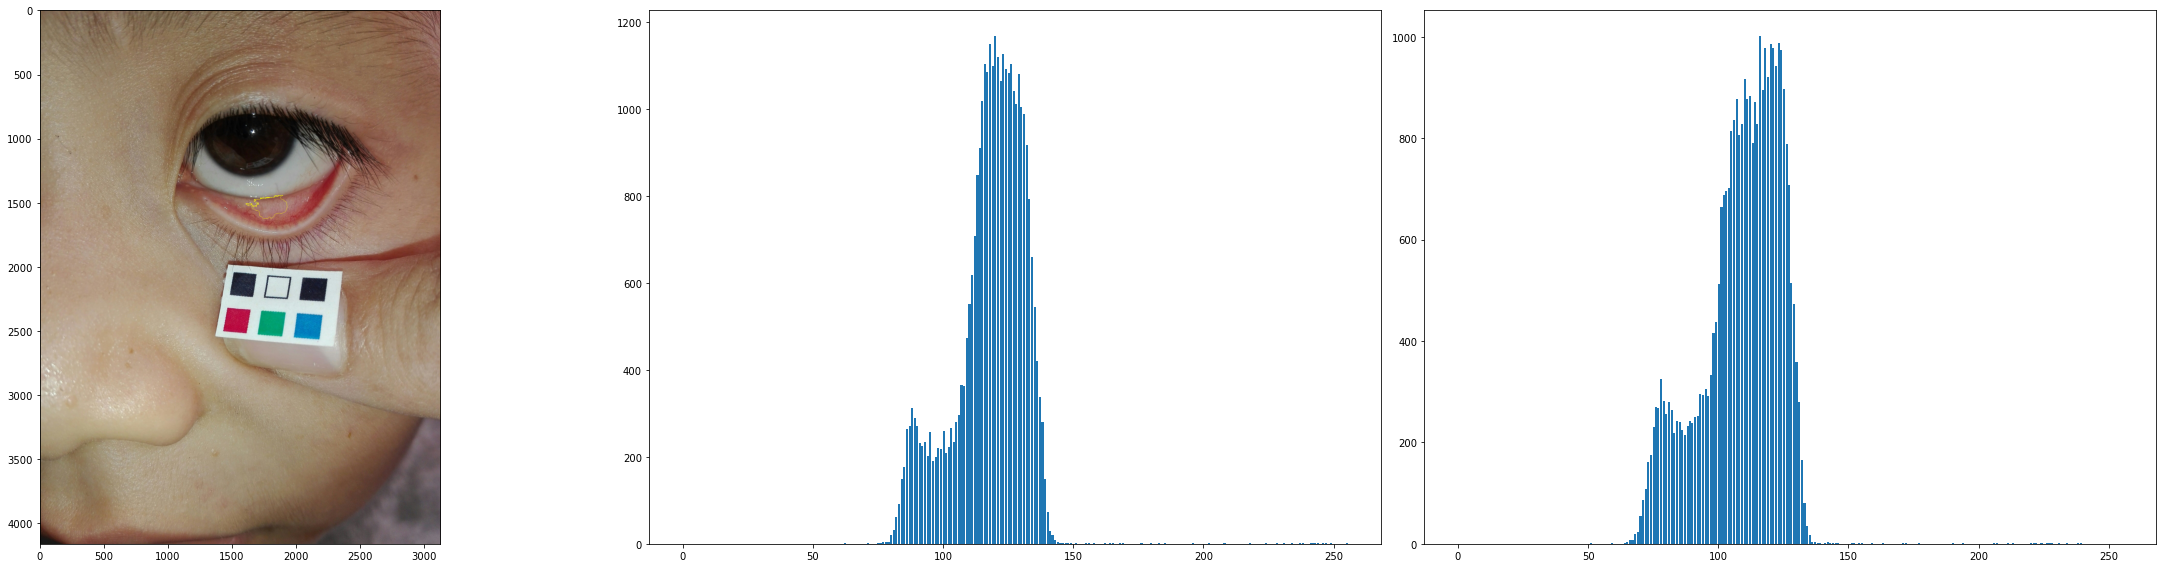

In [ ]:
for i in range(1,11):
    indx=np.where(f[:,:,9]==i)
    hists=v_get_Hist_by_format(f,indx[0],indx[1],np.arange(1,10).reshape(3,3))
    fig, (axi,ax0,ax1) = plt.subplots(ncols=3, figsize=(32, 8))
    axi.imshow(mark_boundaries(img, m_slic==i, mode='inner',background_label=10))
    #axi.imshow(m_slic==i)
    ax0.bar(x=hists[1][0,1,1:],height=hists[0][0,0])
    ax1.bar(x=hists[1][1,1,1:],height=hists[0][0,1])
    #ax2.bar(x=hists[1][2,1,1:],height=hists[0][0,2])
    #ax3.imshow(ROI)
    plt.tight_layout()
    plt.show()

(-0.5, 3119.5, 4159.5, -0.5)

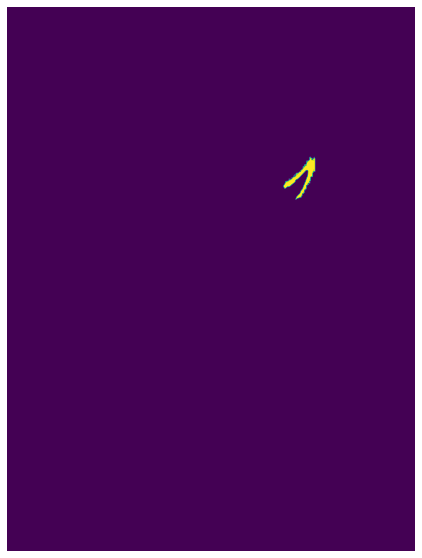

In [109]:
# lum = np.mean(mask,axis=2).astype(int)
# mask1=lum>0

# n_segments=50
fig = plt.figure("Superpixels -- %d segments" % (500),figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(m_slic==1)
plt.axis("off")

In [78]:
print(hists[1][0,1,1:].shape)
print(hists[0][0,0].shape)

(100,)
(100,)


In [18]:
f.shape

(4160, 3120, 10)

In [11]:
hist

import sys
import pathlib
pth=str(pathlib.Path().absolute())
sys.path.append(('\\').join(pth.split('\\')[:-1])+"\\Utils")
from Utilities import *
name='c1anemia-300'
di=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Imagenes_originales\\'+name+'.jpg'
ROI=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Sem_Auto\\eye_'+name+'.jpg'
img = io.imread(di)
ROI = io.imread(ROI)
def get_SD_by_format(f,ind1,ind2,j):
    x=np.mean(f[ind1,ind2,j.reshape(-1,1)],axis=1)
    u=np.std(f[ind1,ind2,j.reshape(-1,1)],axis=1)
    perc=np.percentile(f[ind1,ind2,j.reshape(-1,1)],np.array([0,25,50,75,100]),axis=1)
    hist=np.vectorize(pyfunc=(lambda t:np.histogram(f[ind1,ind2,t],bins=50,range=(0,255))),
                  signature='()->(j),(k)')(j)
    Mo=np.vectorize(pyfunc=(lambda x,y:y[np.where(x==np.max(x))]),signature='(j),(k)->()')(hist[0],hist[1])
    return np.vstack((x,u,perc,Mo))
v_get_SD_by_format=np.vectorize(pyfunc=get_SD_by_format,signature='(x,y,z),(a),(b),(j)->(q,w)')

def get_Hist_by_format(

(-0.5, 3119.5, 4159.5, -0.5)

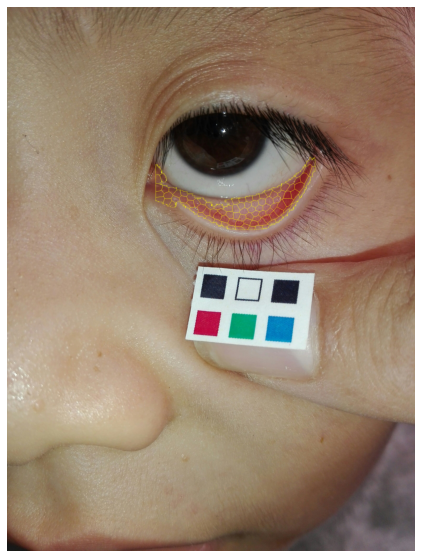

In [30]:
lum = np.mean(mask,axis=2).astype(int)
mask1=lum>0
m_slic = slic(img, n_segments=50,sigma=5,mask=mask1)
n_segments=50
fig = plt.figure("Superpixels -- %d segments" % (500),figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img, m_slic))
plt.axis("off")

In [42]:
lum = np.mean(mask,axis=2).astype(int)
mask1=lum>0
m_slic = slic(img, n_segments=n_segments,sigma=5,slic_zero=True,mask=mask1)



{0: {'rbg_mean': array([0., 0., 0.]),
  'rgb_std': array([38.0659551 , 39.66744111, 38.00063029]),
  'rgb_per': array([0., 0., 0.]),
  'rgb_mo': array([137., 105.,  83.]),
  'lab_mean': array([54.64857372,  5.50447518, 14.32420578]),
  'lab_std': array([15.19058074,  6.50450961,  6.92488897]),
  'lab_per': array([  0.        , -50.61550014, -44.35852413]),
  'lab_mo': array([47.16181578,  2.06923749, 12.70338919]),
  'hsv_mean': array([0.12984874, 0.31039986, 0.59139785]),
  'hsv_std': array([0.17581455, 0.13407073, 0.14480299]),
  'hsv_per': array([0., 0., 0.]),
  'hsv_mo': array([0.07062147, 0.2375    , 0.54117647]),
  'rgb_mean': array([149.2428706 , 127.65172184, 107.39579061])},
 1: {'rbg_mean': array([0., 0., 0.]),
  'rgb_std': array([20.51342778, 26.90007055, 23.27461655]),
  'rgb_per': array([43.,  4.,  0.]),
  'rgb_mo': array([121.,  46.,  45.]),
  'lab_mean': array([36.96501578, 25.38028371, 15.07366126]),
  'lab_std': array([9.21477038, 8.14607418, 4.30907337]),
  'lab_per':

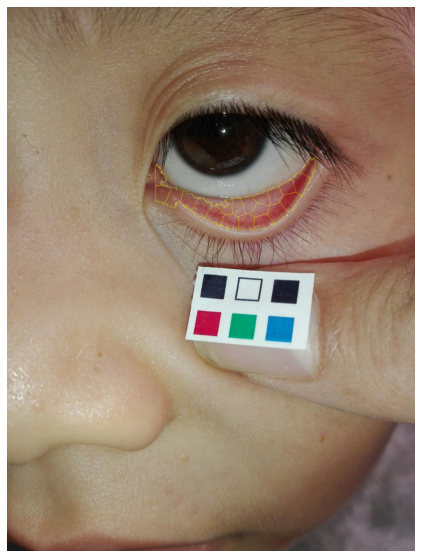

In [259]:
get_Statistical_Descriptors_imp(img,mask,20)

In [8]:
name='c1anemia-300'
di=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Imagenes_recortadas_por_sticker\\SF_'+name+'.jpg'
ROI=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Sem_Auto\\eye_'+name+'.jpg'
#di='/home/grmc1999/Documentos/LIIARPI/hmg/Base_de_Datos/Imagenes_Originales/'+name+'.jpg'
#ROI='/home/grmc1999/Documentos/LIIARPI/hmg/Base_de_Datos/Sem_Auto/eye_'+name+'.jpg'
img = io.imread(di)
ROI = io.imread(ROI)

In [9]:
get_Statistical_Descriptors(img,ROI,n_segments=800)

{0: {'U': array([0.00101313, 0.00205143, 0.00445087, 0.        ]),
  'X': array([1.02643902e-06, 4.20839997e-06, 5.85070239e-06, 0.00000000e+00]),
  'Per': array([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [1., 1., 5., 0.]]),
  'Mo': array([0.])},
 1: {'U': array([56.98336604, 51.40064662, 45.1398836 ,  0.        ]),
  'X': array([138.74227563, 122.55762629, 106.74938695,   1.        ]),
  'Per': array([[  0.,   0.,   0.,   1.],
         [148., 129., 110.,   1.],
         [156., 138., 119.,   1.],
         [165., 147., 129.,   1.],
         [255., 252., 234.,   1.]]),
  'Mo': array([0.])},
 2: {'U': array([35.10173136, 32.23235922, 26.92454291,  0.        ]),
  'X': array([155.43567306, 139.81195308, 113.73487246,   2.        ]),
  'Per': array([[  0.,   0.,   0.,   2.],
         [156., 139., 112.,   2.],
         [160., 143., 116.,   2.],
         [165., 149., 122.,   2.],
         [255., 254., 228.,   2.]]),
  'Mo': arr